# Forecast

In [4]:
!pip install git+https://github.com/patricksferraz/pyaiutils.git@chore/requirements

  Cloning https://github.com/patricksferraz/pyaiutils.git (to revision chore/requirements) to /tmp/pip-req-build-od6bwsy4
  Running command git clone -q https://github.com/patricksferraz/pyaiutils.git /tmp/pip-req-build-od6bwsy4
  Running command git checkout -b chore/requirements --track origin/chore/requirements
  Switched to a new branch 'chore/requirements'
  Branch 'chore/requirements' set up to track remote branch 'chore/requirements' from 'origin'.
/home/ferraz/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ferraz/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.8.1-py3-none-any.whl (189 kB)


In [1]:
# from sklearn.inspection import permutation_importance
# from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import pyaiutils as pai
# import seaborn as sns
import pandas as pd
import numpy as np
# import sklearn
import pickle
import shap
import os

#### Variáveis

In [2]:
DATASET = 'datas/processed'
OUTPUT = 'results/'

#### Funções

Função para verificar a existência do path, caso o caminho não exista, ele é criado
- path: caminho

In [3]:
def sync_path(path: str) -> None:
    lvs = path.split('/')
    for lv in range(1, len(lvs)+1):
        check = '/'.join(lvs[:lv])
        if not os.path.exists(check):
            os.mkdir(check)

Função para exibir o o histórico de treinamento

- history: history de treinamento

In [64]:
def show_history(path: str):
    with open(path, 'rb') as f:
        history = pickle.load(f)
        
    print(history.keys())

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

    ax[0].set_ylabel('Categorical Crossentropy')
    ax[0].plot(range(len(history['loss'])), history['loss'], label='Loss do treino', color='k', linewidth=1.2)
    ax[0].plot(range(len(history['loss'])), history['val_loss'], label='Loss da validação', color='k', linestyle='--', linewidth=1.2)
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Acurácia')
    ax[1].plot(range(len(history['loss'])), history['acc'], label='Train acc', color='k', linewidth=1.2)
    ax[1].plot(range(len(history['loss'])), history['val_acc'], label='Validation acc', color='k', linestyle='--', linewidth=1.2)
    # ax[1].plot(range(len(history['loss'])), history['categorical_accuracy'], label='Acurácia do treino', color='k', linewidth=1.2)
    # ax[1].plot(range(len(history['loss'])), history['val_categorical_accuracy'], label='Acurácia da validação', color='k', linestyle='--', linewidth=1.2)
    ax[1].legend()
    
    plt.show()

Metrics

In [5]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [7]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Função para avaliação do modelo
- model: modelo
- x_test: dataframe de entrada
- y_test: dataframe alvo
- class_names: classes
- path: caminho para armazenar os resultados

In [8]:
def evaluate(
    model: tf.keras.Sequential,
    x_test: np.ndarray,
    y_test: np.ndarray,
    class_names: [str],
    path: str
) -> None:
    y_pred = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
    display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

## Classificação

Algoritmos de classificação

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Métricas de avaliação

Matriz de Confusão | Recall vs Precision | Equação de 4 diferentes métricas
- | - | -
![](https://miro.medium.com/max/1400/1*N6I3pi0prhiJ_Y85HAx4wA.png) | ![](https://miro.medium.com/max/700/0*uhuG2rhX6XzNC43X.png) | ![](https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png)

### COVID/OUTRA-SRAG

Carregando dataframe:

|sintomas|comorbidades|sexo|idade|SRAG|desfecho|
|--|--|--|--|--|--|
|1. Sim|1. Sim|1: Masculino||0. Não Covid|1. Cura|
|2. Não|2. Não|2: Feminino||1. Covid|2. Óbito|
|9. Ignorado|9. Ignorado|9: Ignorado|||9. Ignorado|


In [9]:
df = pd.read_csv(f'{DATASET}/SRAG.csv.gz', low_memory=False, compression='gzip')
df

,idade,sexo,febre,tosse,dispneia,dor de garganta,diarréia,cardiopatia,SRAG,desfecho,desconforto respiratório,saturação baixa,ano fonte
0,57,1,1.0,1.0,1.0,2.0,1.0,9.0,0.0,1.0,0.0,0.0,2009
1,19,1,1.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,2009
2,19,1,1.0,1.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,2009
3,1,2,1.0,1.0,2.0,1.0,2.0,9.0,0.0,1.0,0.0,0.0,2009
4,0,1,1.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332248,33,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,2021
2332249,57,1,1.0,1.0,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,2021
2332250,35,1,1.0,1.0,1.0,2.0,2.0,0.0,1.0,NaN,2.0,1.0,2021
2332251,78,2,2.0,1.0,2.0,2.0,1.0,1.0,1.0,NaN,2.0,2.0,2021


In [10]:
df['SRAG'].value_counts()

1.0    1807429
0.0     524824
Name: SRAG, dtype: int64

Listando as colunas existentes

In [11]:
df.columns

Index(['idade', 'sexo', 'febre', 'tosse', 'dispneia', 'dor de garganta',
       'diarréia', 'cardiopatia', 'SRAG', 'desfecho',
       'desconforto respiratório', 'saturação baixa', 'ano fonte'],
      dtype='object')

Delimitando as colunas de interesse

In [12]:
symptoms = [
    'febre',
    'tosse',
    'dor de garganta',
    'dispneia',
    'desconforto respiratório',
    'saturação baixa',
    'diarréia',
]
comorbidities = [
    'cardiopatia',
]

Aplicando One Hot Encondig

In [13]:
# alt_cols = [*symptoms, *comorbidities, 'sexo']
# ohe_cols = []
# for col in alt_cols:
#     covid_ncovid.loc[:, f'{col}_0'] = 1-covid_ncovid['CS_SEXO'].values
#     covid_ncovid.loc[:, f'{col}_1'] = covid_ncovid['CS_SEXO']
#     covid_ncovid.drop(columns=[col], inplace=True)
#     ohe_cols.append(f'{col}_0')
#     ohe_cols.append(f'{col}_1')
# covid_ncovid

Colunas para estudo

In [14]:
x_cols = [
    *symptoms,
    *comorbidities,
    'sexo',
    'idade',
]
y_cols = ['SRAG']

Split dataset
- train 60
- test 20
- val 20

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    df[x_cols],
    df[y_cols],
    test_size=0.2,
    random_state=1
)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train,
    y_train,
    test_size=0.25,
    random_state=1
)

Normalizando os dados de entrada

In [17]:
x_scaler = MinMaxScaler((0,1))

x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)

In [18]:
scalers = f'{OUTPUT}/scalers'

In [19]:
pickle.dump(x_scaler, open(f'{scalers}/xscaler.pkl', 'wb'))

In [20]:
dataset = f'{OUTPUT}/dataset'

In [21]:
pd.DataFrame(x_train, columns=x_cols).to_csv(f'{dataset}/xtrain.csv', index=False)
pd.DataFrame(y_train, columns=y_cols).to_csv(f'{dataset}/ytrain.csv', index=False)
pd.DataFrame(x_val, columns=x_cols).to_csv(f'{dataset}/xval.csv', index=False)
pd.DataFrame(y_val, columns=y_cols).to_csv(f'{dataset}/yval.csv', index=False)
pd.DataFrame(x_test, columns=x_cols).to_csv(f'{dataset}/xtest.csv', index=False)
pd.DataFrame(y_test, columns=y_cols).to_csv(f'{dataset}/ytest.csv', index=False)

Conversão da saída para categorical (One Hot Encoding)

In [22]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [23]:
classes_target = ['Outra-SRAG', 'Covid-19']
pd.DataFrame(y_train, columns=classes_target).to_csv(f'{dataset}/ytrain_ohe.csv', index=False)
pd.DataFrame(y_val, columns=classes_target).to_csv(f'{dataset}/yval_ohe.csv', index=False)
pd.DataFrame(y_test, columns=classes_target).to_csv(f'{dataset}/ytest_ohe.csv', index=False)

#### RNA (MLP)

In [24]:
model_mlp = f'{OUTPUT}/models/mlp'

otimizador

In [27]:
model_o = tf.keras.models.load_model(
    f'{model_mlp}/init_weights_nsgaii_best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model_o.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                969       
_________________________________________________________________
dense_3 (Dense)              (None, 88)                4576      
_________________________________________________________________
dense_4 (Dense)              (None, 76)                6764      
_________________________________________________________________
dense_5 (Dense)              (None, 51)                3927      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 104       
Total params: 16,340
Trainable params: 16,340
Non-trainable params: 0
_______________________________________________________

dict_keys(['val_loss', 'val_categorical_accuracy', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'loss', 'categorical_accuracy', 'precision_m', 'recall_m', 'f1_m'])


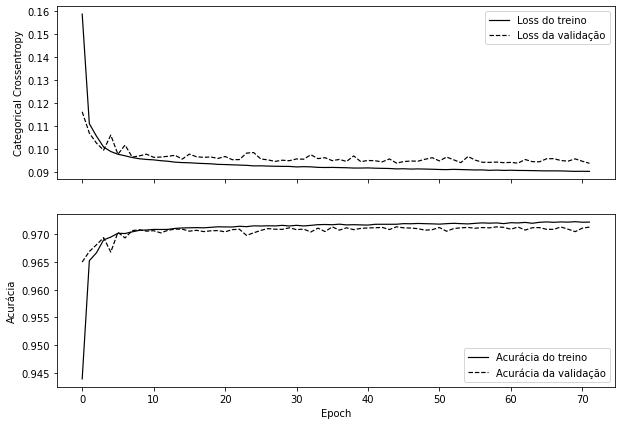

In [63]:
show_history(f'{model_mlp}/history_nsgaii_best_model.pk')

---

In [35]:
model = tf.keras.models.load_model(
    f'{model_mlp}/best_model.h5', # f'{MODELS_OUT}/optimizer/covid-ncovid/mlp_scis/final_weights_nsgaii_best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 51)                561       
                                                                 
 dense_1 (Dense)             (None, 88)                4576      
                                                                 
 dropout (Dropout)           (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 76)                6764      
                                                                 
 dense_3 (Dense)             (None, 51)                3927      
                                                                 
 dense_4 (Dense)             (None, 2)                 104       
                                                                 
Total params: 15,932
Trainable params: 15,932
Non-trainable par

In [54]:
def mlp_model(input_shape: ()) -> tf.keras.Model:
    tf.keras.backend.clear_session()
#     tf.random.set_seed(0)

    opt = tf.keras.optimizers.SGD(learning_rate=0.41001897516490954)
    auc = tf.keras.metrics.AUC()

    model = tf.keras.models.Sequential(name='mlp')
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(units=51, activation='elu'))
    model.add(tf.keras.layers.Dense(units=88, activation='softsign'))
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(units=76, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=51, activation='elu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    return model

In [52]:
monitor = 'val_loss'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{model_mlp}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=f'{model_mlp}/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-4, mode='min'),
]

In [55]:
model = mlp_model((x_train.shape[1],))
# train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,#72,
    batch_size=179,
    callbacks=callbacks
)

# Uncomment if you don't use callbacks
# model.save(f'{path_mlpcovid}/best_model.h5')

with open(f'{model_mlp}/history_best_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/200
7818/7818 [==============================] - 25s 3ms/step - loss: 0.2884 - acc: 0.9407 - precision_m: 0.9407 - recall_m: 0.9407 - f1_m: 0.9407 - auc: 0.9740 - val_loss: 0.2207 - val_acc: 0.9668 - val_precision_m: 0.9668 - val_recall_m: 0.9668 - val_f1_m: 0.9668 - val_auc: 0.9822 - lr: 0.4100
Epoch 2/200
7818/7818 [==============================] - 24s 3ms/step - loss: 0.2192 - acc: 0.9650 - precision_m: 0.9650 - recall_m: 0.9650 - f1_m: 0.9650 - auc: 0.9832 - val_loss: 0.2182 - val_acc: 0.9684 - val_precision_m: 0.9684 - val_recall_m: 0.9684 - val_f1_m: 0.9684 - val_auc: 0.9841 - lr: 0.4100
Epoch 3/200
7818/7818 [==============================] - 23s 3ms/step - loss: 0.2127 - acc: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674 - f1_m: 0.9674 - auc: 0.9844 - val_loss: 0.2068 - val_acc: 0.9677 - val_precision_m: 0.9677 - val_recall_m: 0.9677 - val_f1_m: 0.9677 - val_auc: 0.9864 - lr: 0.4100
Epoch 4/200
7818/7818 [==============================] - 22s 3ms/step - loss: 0.2109 

dict_keys(['loss', 'acc', 'precision_m', 'recall_m', 'f1_m', 'auc', 'val_loss', 'val_acc', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'val_auc', 'lr'])


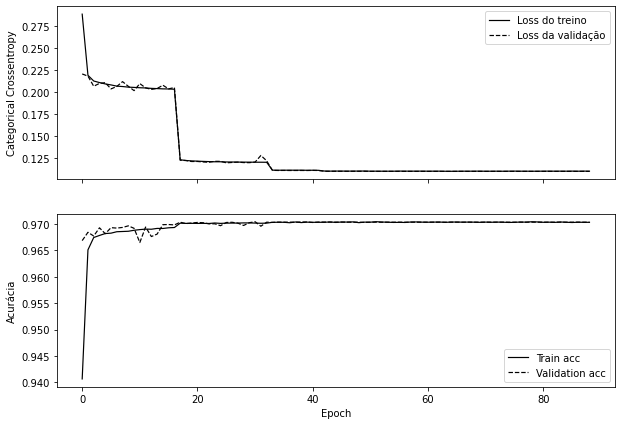

In [65]:
show_history(f'{model_mlp}/history_best_model.pkl')

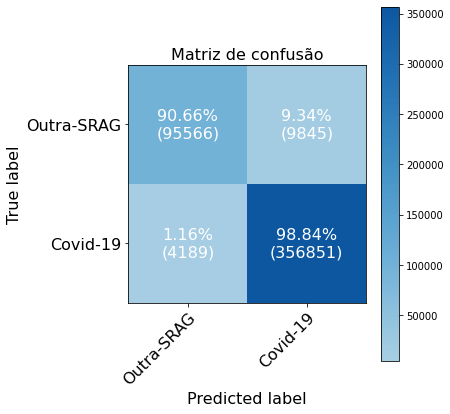

None

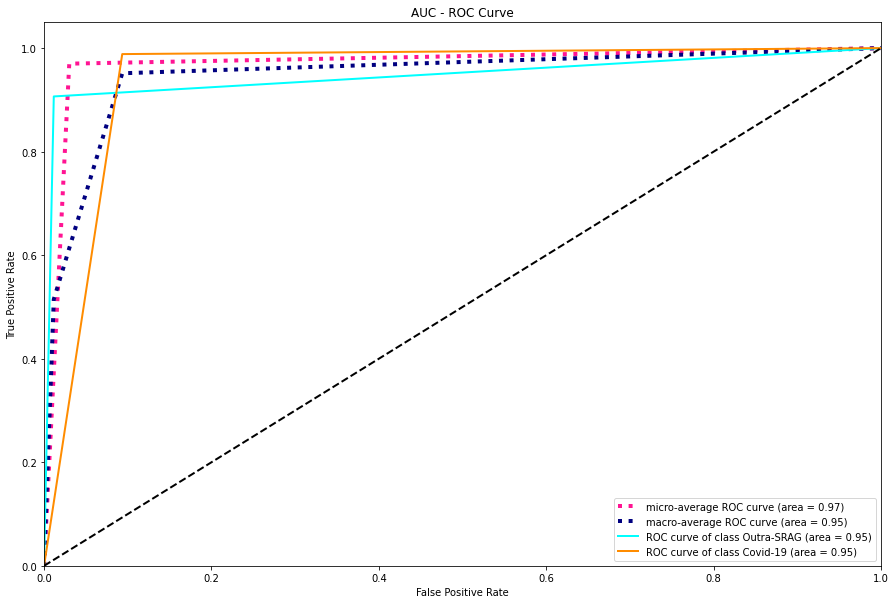

None

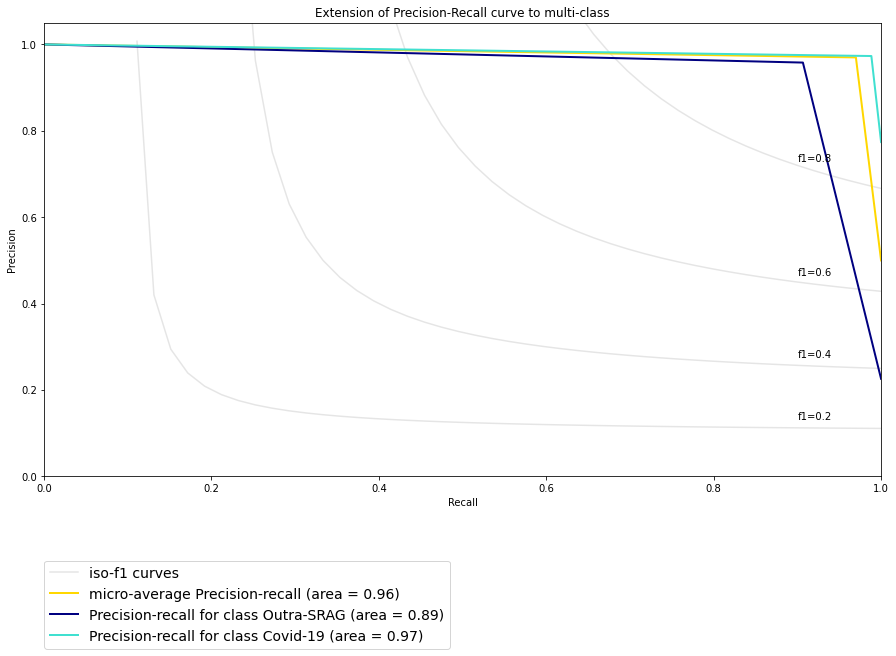

None

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,Outra-SRAG,0.93,0.95,0.89,0.96,0.91,0.99,0.97
1,Covid-19,0.98,0.95,0.97,0.97,0.99,0.91,0.97
2,Média,0.96,0.95,0.93,0.96,0.95,0.95,0.97


In [36]:
evaluate(
    model=model,
    x_test=x_test,
    y_test=y_test,
    class_names=['Outra-SRAG', 'Covid-19'],
    path=model_mlp
)

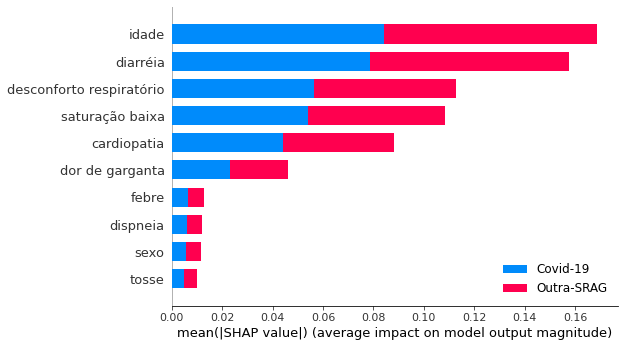

In [38]:
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
e = shap.GradientExplainer(model, background)
samples = x_test[np.random.choice(x_test.shape[0], 50000, replace=False)]
shap_values = e.shap_values(samples)

shap.summary_plot(shap_values, samples, feature_names=x_cols, class_names=['Outra-SRAG', 'Covid-19'], show=False)
plt.savefig(f'{model_mlp}/shap_summary.png')
plt.show()

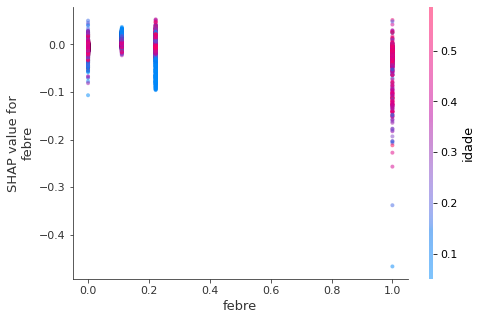

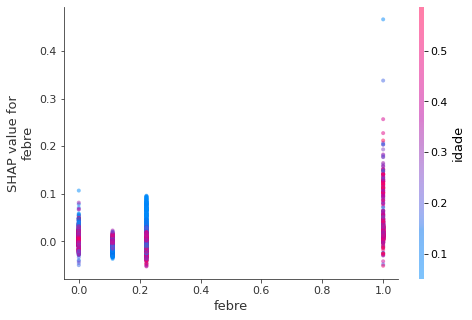

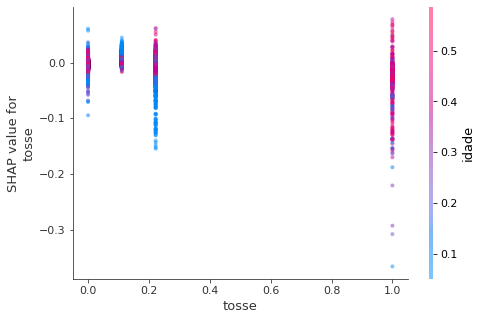

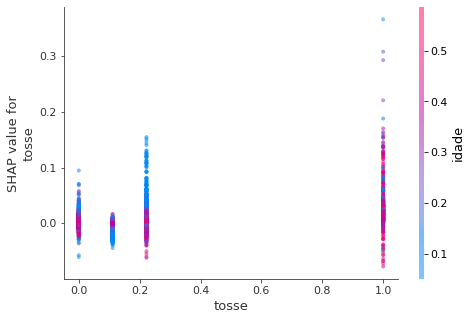

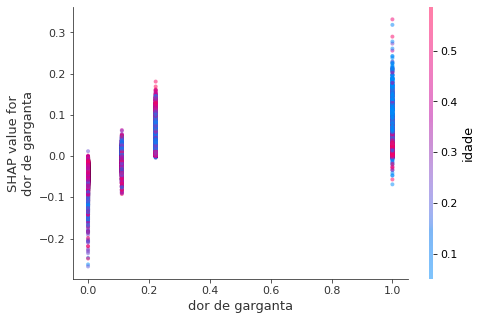

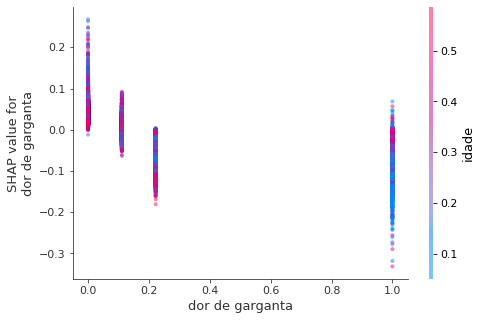

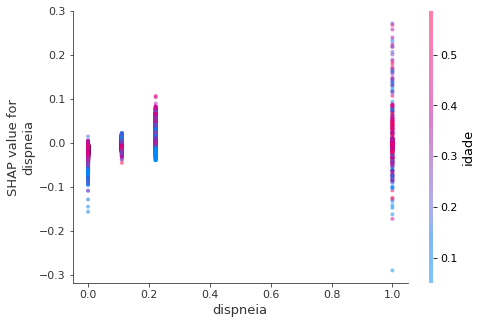

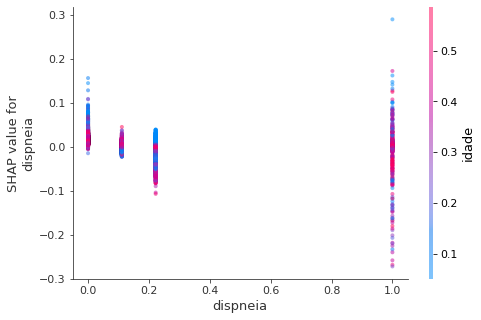

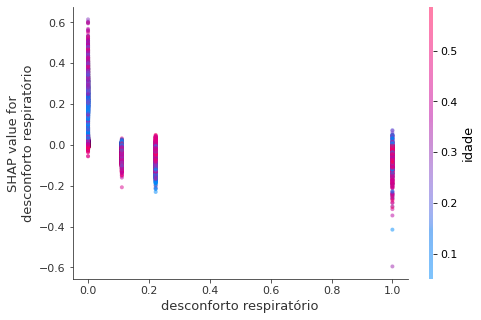

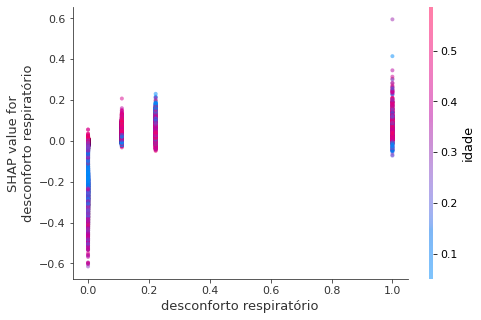

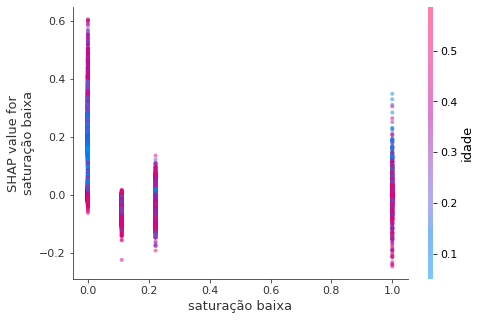

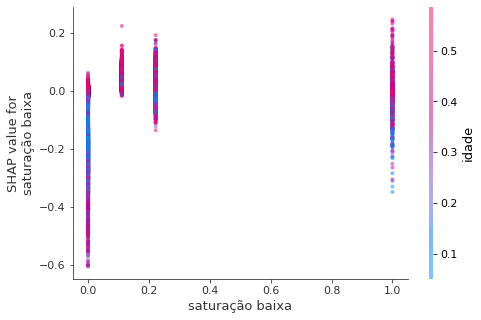

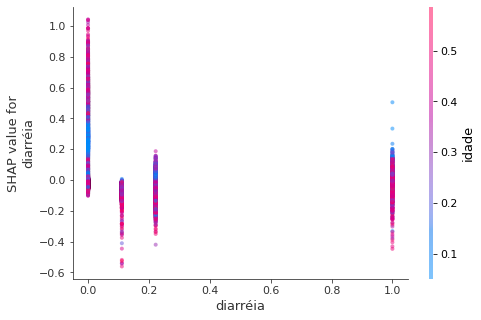

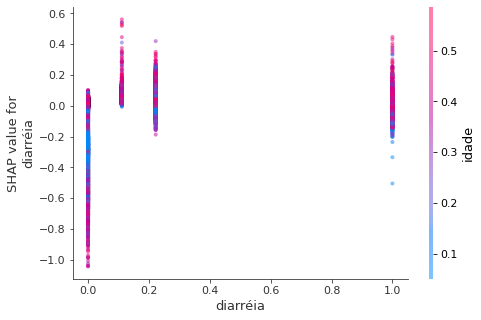

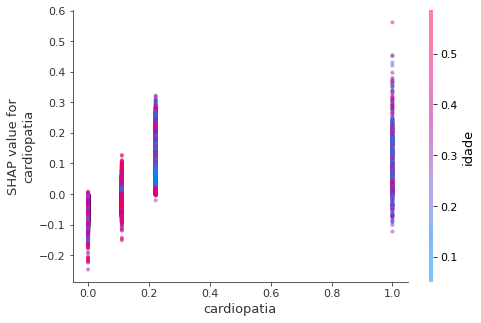

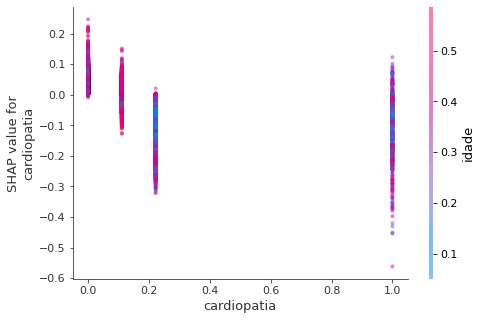

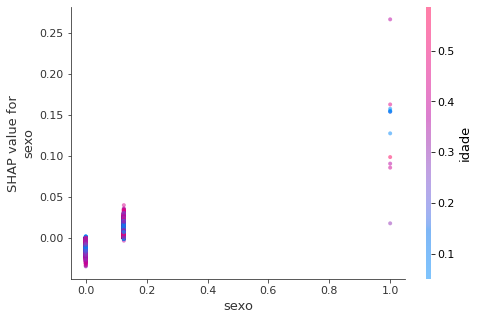

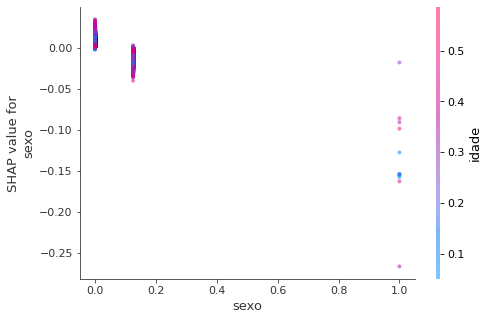

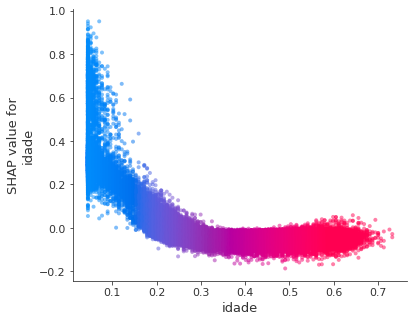

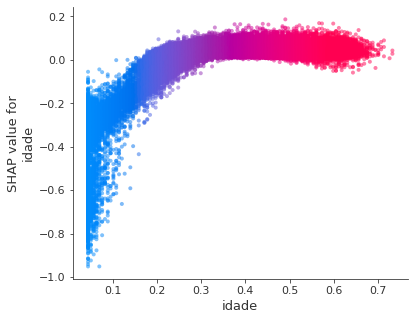

In [44]:
class_names = ['Outra-SRAG', 'Covid-19']
for feat in x_cols:
    for clss in range(len(class_names)):
        shap.dependence_plot(
            feat,
            shap_values[clss],
            samples,
            interaction_index='idade',
            alpha=0.5,
            feature_names=x_cols,
            show=False
        )
        plt.savefig(f'{model_mlp}/dependence/{class_names[clss]}_{feat}.png')

#### RNA (MLP) K-FOLD

In [45]:
mlp_kfold = f'{model_mlp}/kfold'

Epoch 1/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.2724 - acc: 0.9440 - precision_m: 0.9440 - recall_m: 0.9440 - f1_m: 0.9440 - auc: 0.9769
Epoch 2/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.2105 - acc: 0.9668 - precision_m: 0.9668 - recall_m: 0.9668 - f1_m: 0.9668 - auc: 0.9846
Epoch 3/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.2081 - acc: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674 - f1_m: 0.9674 - auc: 0.9853
Epoch 4/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.2061 - acc: 0.9677 - precision_m: 0.9677 - recall_m: 0.9677 - f1_m: 0.9677 - auc: 0.9859
Epoch 5/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.2049 - acc: 0.9677 - precision_m: 0.9677 - recall_m: 0.9677 - f1_m: 0.9677 - auc: 0.9864
Epoch 6/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.2041 - acc: 0.9681 - precision_m: 0.9681 - recall_m: 0.9681 - f1_m: 0

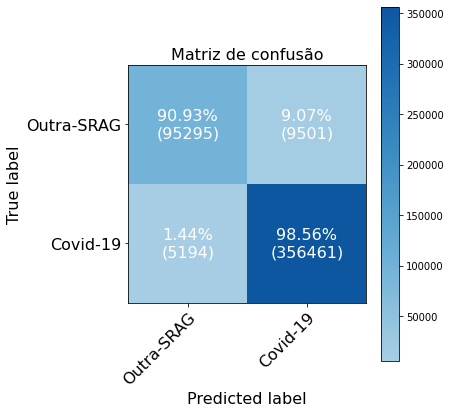

None

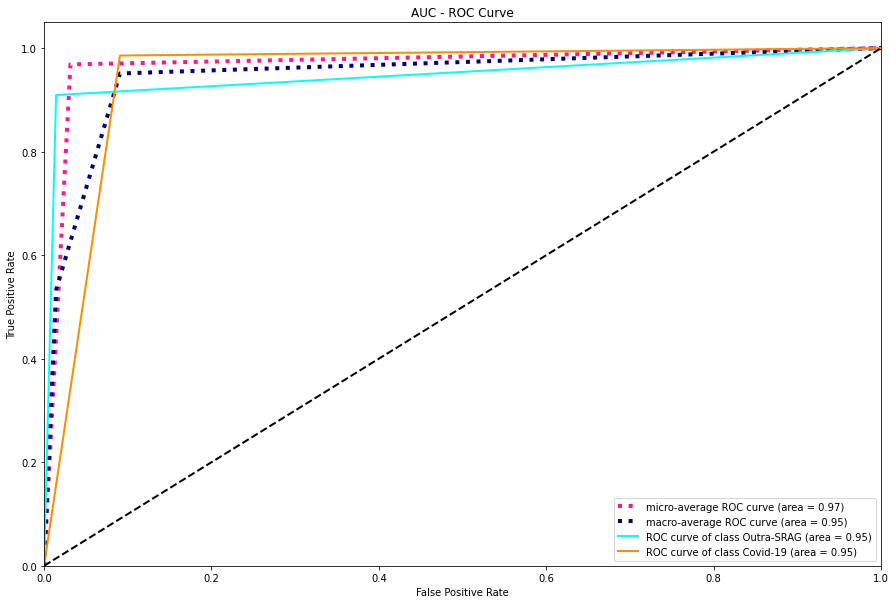

None

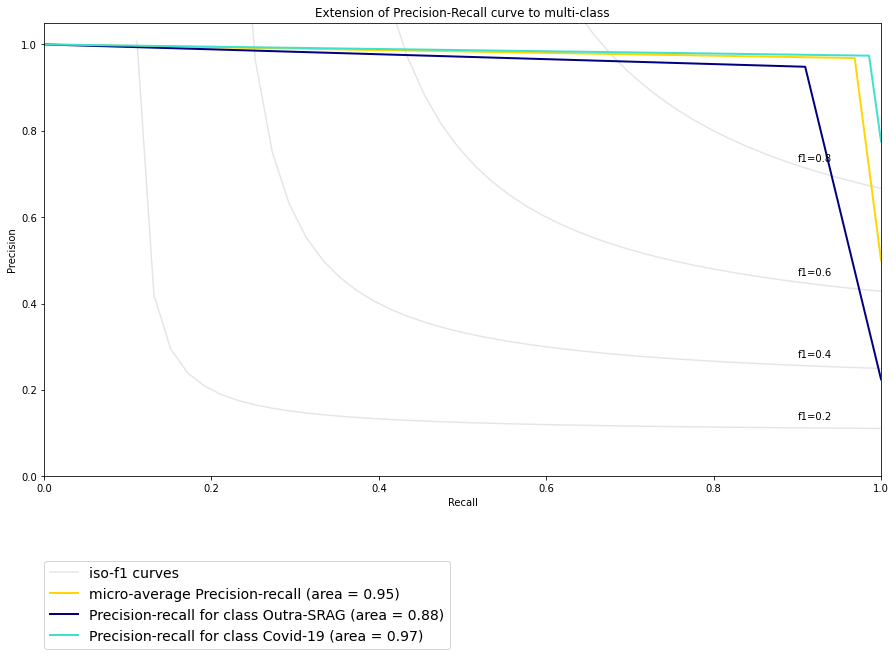

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.88       0.95    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.92       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.3914 - acc: 0.8908 - precision_m: 0.8908 - recall_m: 0.8908 - f1_m: 0.8908 - auc: 0.9458
Epoch 2/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2219 - acc: 0.9655 - precision_m: 0.9655 - recall_m: 0.9655 - f1_m: 0.9655 - auc: 0.9830
Epoch 3/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2144 - acc: 0.9675 - precision_m: 0.9675 - recall_m: 0.9675 - f1_m: 0.9675 - auc: 0.9843
Epoch 4/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2120 - acc: 0.9679 - precision_m: 0.9679 - recall_m: 0.9679 

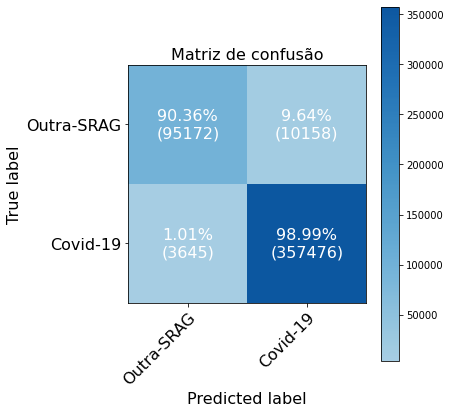

None

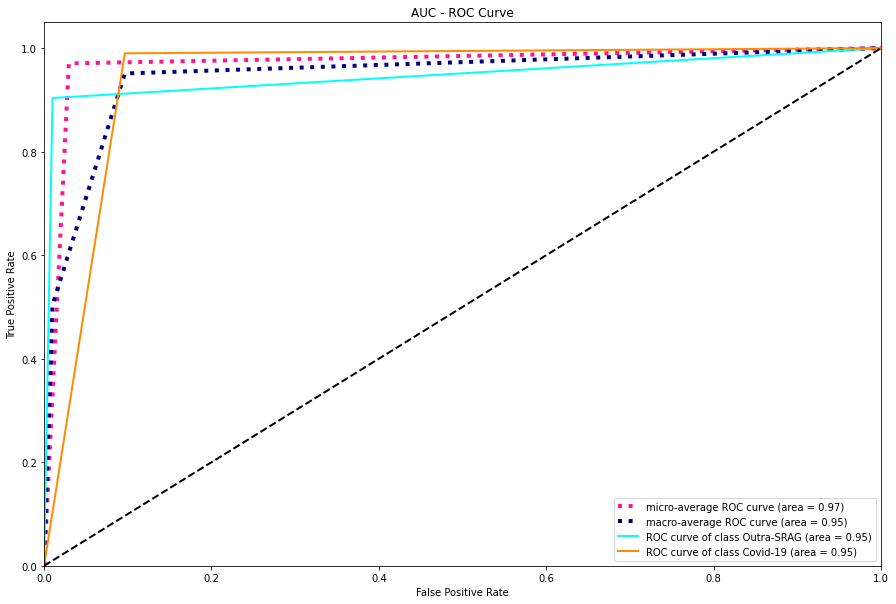

None

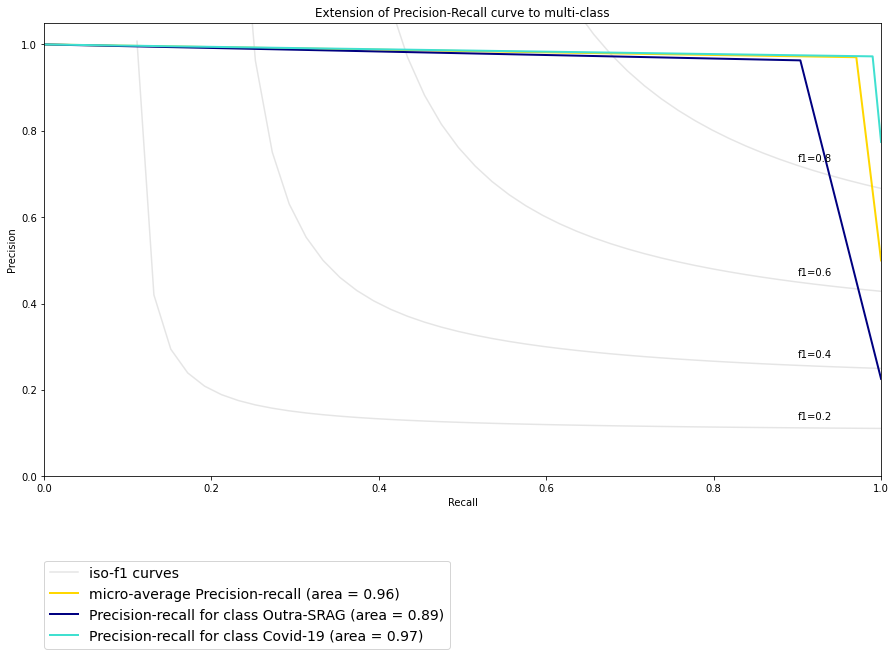

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.90         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.90   
2       Média  0.96     0.95     0.93       0.96    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.3821 - acc: 0.8943 - precision_m: 0.8943 - recall_m: 0.8943 - f1_m: 0.8943 - auc: 0.9488
Epoch 2/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2244 - acc: 0.9635 - precision_m: 0.9635 - recall_m: 0.9635 - f1_m: 0.9635 - auc: 0.9834
Epoch 3/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2137 - acc: 0.9669 - precision_m: 0.9669 - recall_m: 0.9669 - f1_m: 0.9669 - auc: 0.9849
Epoch 4/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2109 - acc: 0.9676 - precision_m: 0.9676 - recall_m: 0.9676 

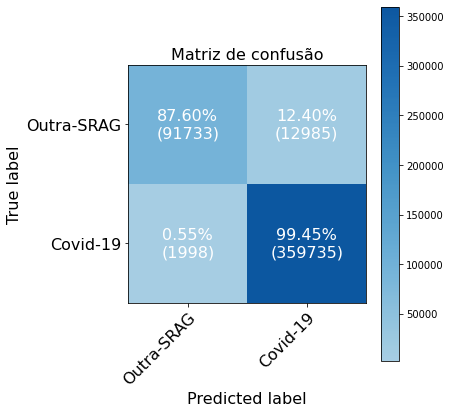

None

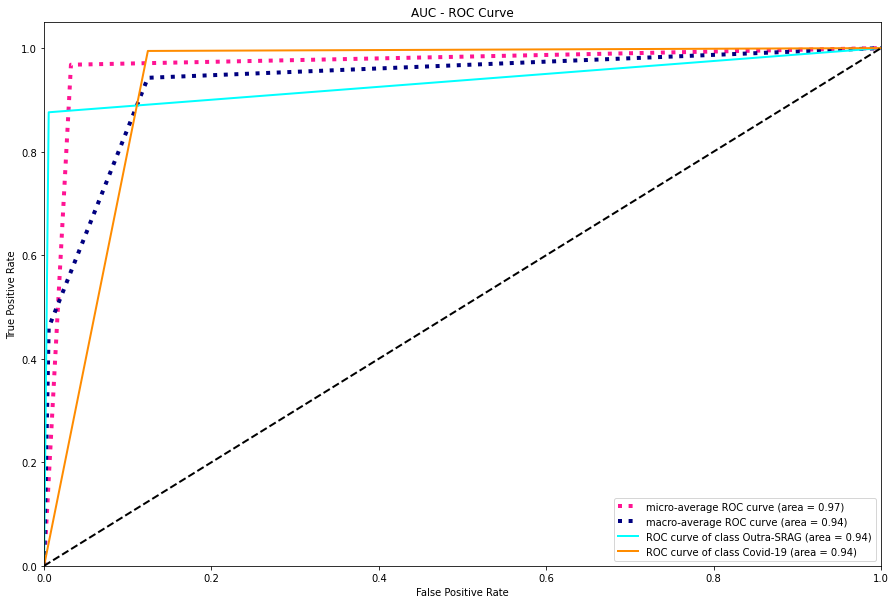

None

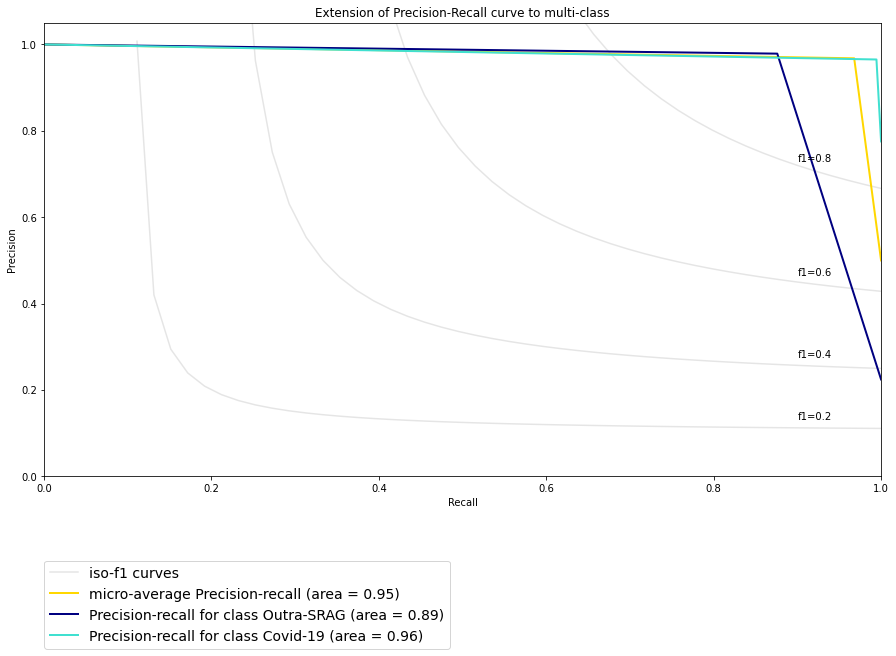

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.92     0.94     0.89       0.98    0.88         0.99   
1    Covid-19  0.98     0.94     0.96       0.97    0.99         0.88   
2       Média  0.95     0.94     0.92       0.98    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/89
10424/10424 [==============================] - 23s 2ms/step - loss: 0.2741 - acc: 0.9444 - precision_m: 0.9444 - recall_m: 0.9444 - f1_m: 0.9444 - auc: 0.9769
Epoch 2/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.2148 - acc: 0.9661 - precision_m: 0.9661 - recall_m: 0.9661 - f1_m: 0.9661 - auc: 0.9844
Epoch 3/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.2113 - acc: 0.9671 - precision_m: 0.9671 - recall_m: 0.9671 - f1_m: 0.9671 - auc: 0.9851
Epoch 4/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.2096 - acc: 0.9675 - precision_m: 0.9675 - recall_m: 0.9675 

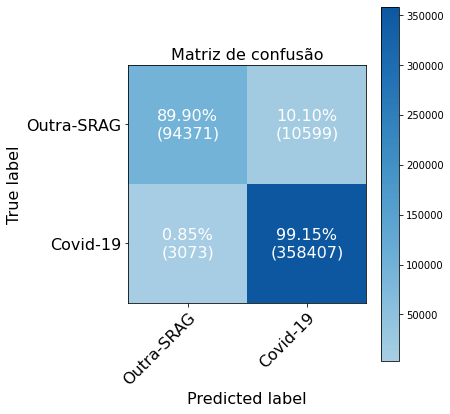

None

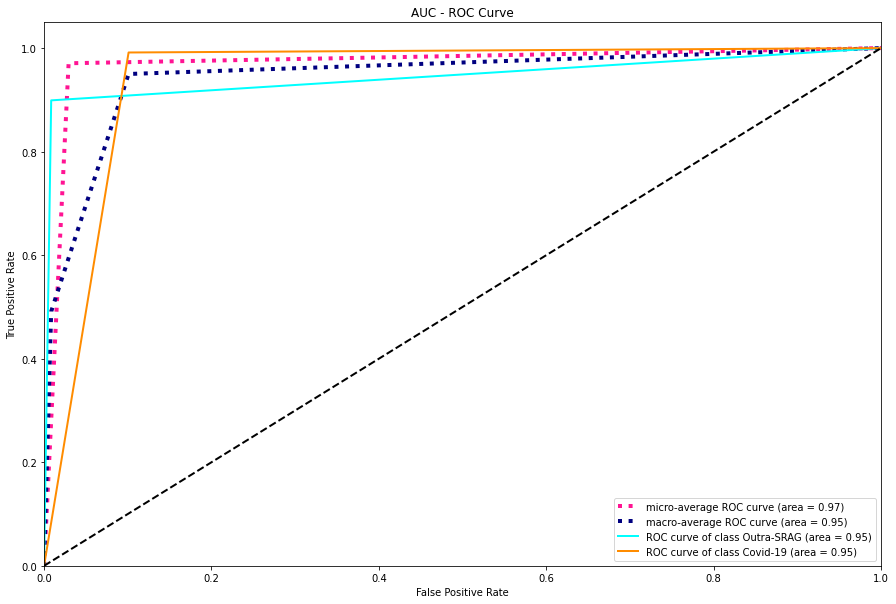

None

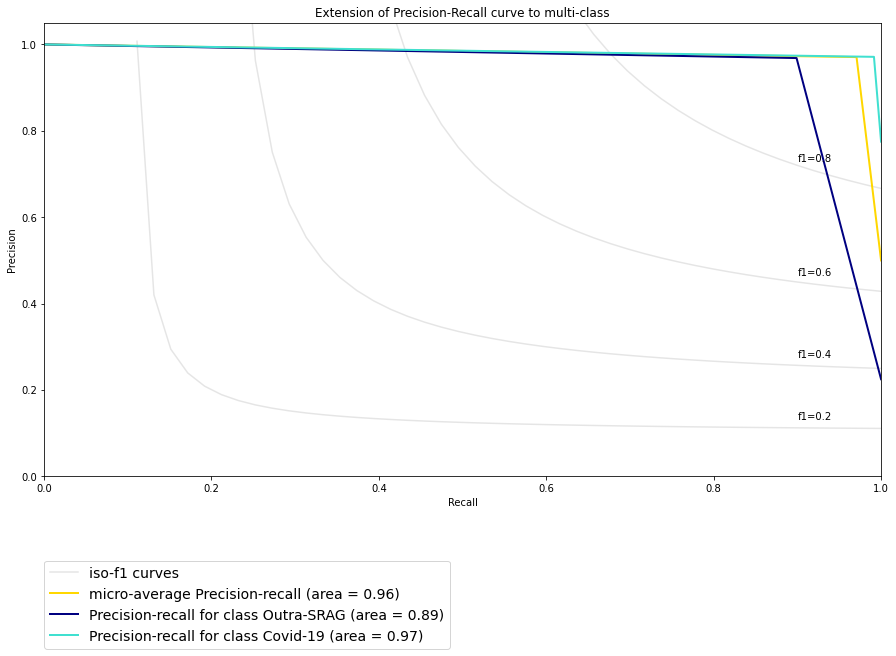

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.97    0.90         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.90   
2       Média  0.96     0.95     0.93       0.97    0.94         0.94   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/89
10424/10424 [==============================] - 23s 2ms/step - loss: 0.2718 - acc: 0.9465 - precision_m: 0.9465 - recall_m: 0.9465 - f1_m: 0.9465 - auc: 0.9773
Epoch 2/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.2154 - acc: 0.9666 - precision_m: 0.9666 - recall_m: 0.9666 - f1_m: 0.9666 - auc: 0.9844
Epoch 3/89
10424/10424 [==============================] - 22s 2ms/step - loss: 0.2124 - acc: 0.9671 - precision_m: 0.9671 - recall_m: 0.9671 - f1_m: 0.9671 - auc: 0.9852: 0s - loss: 0.2124 - acc: 0.9671 - precision_m: 0.9671 - recall_m: 0.9671 - f1_m: 0.9671
Epoch 4/89
10424/10424 [============================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10424/10424 [==============================] - 21s 2ms/step - loss: 0.2019 - acc: 0.9695 - precision_m: 0.9695 - recall_m: 0.9695 - f1_m: 0.9695 - auc: 0.9869
Epoch 23/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2018 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9869
Epoch 24/89
10424/10424 [==============================] - 20s 2ms/step - loss: 0.2017 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9869
Epoch 25/89
10424/10424 [==============================] - 21s 2ms/step - loss: 0.2016 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9870
Epoch 26/89
10424/10424 [==============================] - 20s 2ms/step - loss: 0.2014 - acc: 0.9696 - precision_m: 0.9695 - recall_m: 0.9695 - f1_m: 0.9695 - auc: 0.9870
Epoch 27/89
10424/10424 [==============================] - 20s 2ms/step - loss: 0.2013 - acc: 0.9696 - precision_m: 0.9696 - recall_m: 0.9696 - f1_m: 0.9696 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10424/10424 [==============================] - 21s 2ms/step - loss: 0.2007 - acc: 0.9696 - precision_m: 0.9696 - recall_m: 0.9696 - f1_m: 0.9696 - auc: 0.9870
Epoch 34/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.1995 - acc: 0.9700 - precision_m: 0.9699 - recall_m: 0.9699 - f1_m: 0.9699 - auc: 0.9872
Epoch 60/89
10424/10424 [==============================] - 24s 2ms/step - loss: 0.1994 - acc: 0.9700 - precision_m: 0.9700 - recall_m: 0.9700 - f1_m: 0.9700 - auc: 0.9873
Epoch 61/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.1993 - acc: 0.9700 - precision_m: 0.9699 - recall_m: 0.9699 - f1_m: 0.9699 - auc: 0.9872
Epoch 62/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.1993 - acc: 0.9699 - precision_m: 0.9699 - recall_m: 0.9699 - f1_m: 0.9699 - auc: 0.9872
Epoch 63/89
10424/10424 [==============================] - 25s 2ms/step - loss: 0.1993 - acc: 0.9699 - precision_m: 0.9699 - recall_m: 0.9699 - f1_m: 0.9699 

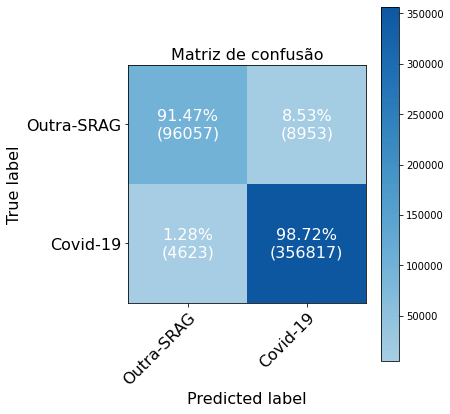

None

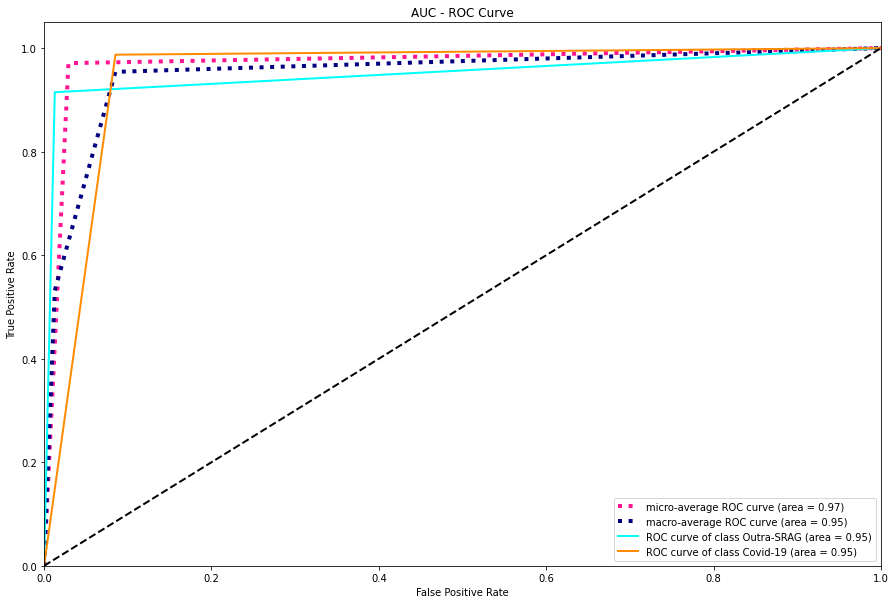

None

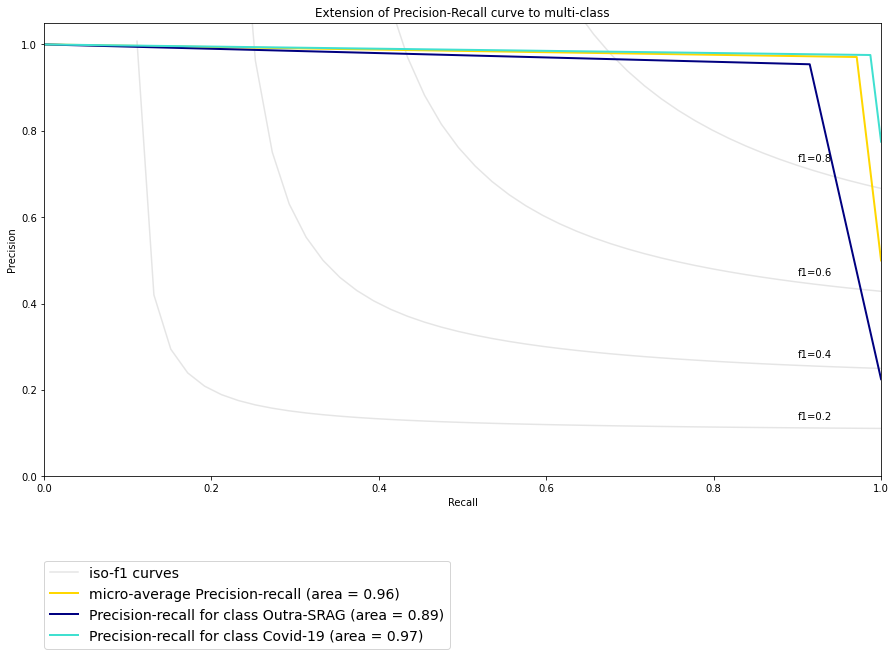

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.95    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.98    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  


In [55]:
x = df[x_cols]
y = df[y_cols]

all_metrics = []
seed = 0
i = 0

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):
    
    x_scaler = MinMaxScaler(feature_range=(0, 1))
#     y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_train = x_scaler.fit_transform(x.values[train])
    y_train = tf.keras.utils.to_categorical(y.values[train])
#     y_train = y_scaler.fit_transform(y.values[train])

    # Load model
    model = mlp_model((x_train.shape[1],))
    # Fit the model
    model.fit(x_train, y_train, epochs=89, batch_size=179)
    
    # evaluate the model
    x_test = x_scaler.transform(x.values[test])
    y_pred = model.predict(x_test)
    y_true = y.values[test]
    y_pred = np.argmax(y_pred, axis=1)
    
    out = f'{mlp_kfold}/{i}fold'
    sync_path(out)
    
    lbs = ['Outra-SRAG', 'Covid-19']
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true.ravel(), y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)
    i+=1

Média e desvio padrão dos k-folds

In [56]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} {i}-fold"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{mlp_kfold}/{all_metrics[0].loc[target].Classes}_metrics.csv')

,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Outra-SRAG 0-fold,0.93,0.95,0.88,0.95,0.91,0.99,0.97
Outra-SRAG 1-fold,0.93,0.95,0.89,0.96,0.90,0.99,0.97
Outra-SRAG 2-fold,0.92,0.94,0.89,0.98,0.88,0.99,0.97
Outra-SRAG 3-fold,0.93,0.95,0.89,0.97,0.90,0.99,0.97
Outra-SRAG 4-fold,0.93,0.95,0.89,0.95,0.91,0.99,0.97
Avg,0.93,0.95,0.89,0.96,0.90,0.99,0.97
Std,0.00,0.00,0.00,0.01,0.01,0.00,0.00


,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Covid-19 0-fold,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Covid-19 1-fold,0.98,0.95,0.97,0.97,0.99,0.90,0.97
Covid-19 2-fold,0.98,0.94,0.96,0.97,0.99,0.88,0.97
Covid-19 3-fold,0.98,0.95,0.97,0.97,0.99,0.90,0.97
Covid-19 4-fold,0.98,0.95,0.97,0.98,0.99,0.91,0.97
Avg,0.98,0.95,0.97,0.97,0.99,0.90,0.97
Std,0.00,0.00,0.00,0.00,0.00,0.01,0.00


#### RNA (CNN1D)

Preparação dos dados para CNN1D

In [24]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))

np.save(f'{dataset}/xtrain_cnn.npy', x_train)
np.save(f'{dataset}/xtest_cnn.npy', x_val)
np.save(f'{dataset}/xval_cnn.npy', x_val)

np.save(f'{dataset}/ytrain_ohe_cnn.npy', y_train)
np.save(f'{dataset}/ytest_ohe_cnn.npy', y_test)
np.save(f'{dataset}/yval_ohe_cnn.npy', y_val)

In [25]:
model_cnn = f'{OUTPUT}/models/cnn'

In [ ]:
model = tf.keras.models.load_model(
    f'{model_cnn}/best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model.summary()

In [26]:
def cnn_model(input_shape: ()) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    # tf.random.set_seed(0)

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.148264721208473)
    auc = tf.keras.metrics.AUC()

    model = tf.keras.models.Sequential(name='cnn1d')
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv1D(filters=54, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same'))
    model.add(tf.keras.layers.Conv1D(filters=54, kernel_size=3, padding='same', activation='softmax'))
    model.add(tf.keras.layers.Conv1D(filters=54, kernel_size=3, padding='same', activation='tanh'))
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    return model

In [27]:
monitor = 'val_loss'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{model_cnn}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=f'{model_cnn}/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-5, mode='min'),
]

In [29]:
model = cnn_model((x_train.shape[1],x_train.shape[2]))
# train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=179,
    callbacks=callbacks
)

# Uncomment if you don't use callbacks
# model.save(f'{path_cnncovid}/best_model.h5')

with open(f'{model_cnn}/history_best_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

2021-12-11 21:14:37.579327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-11 21:14:37.579605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 21:14:37.579693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-11 21:14:37.579755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-11 21:14:37.579845: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/200
7818/7818 [==============================] - 36s 5ms/step - loss: 0.2567 - acc: 0.9045 - precision_m: 0.9045 - recall_m: 0.9045 - f1_m: 0.9045 - auc: 0.9575 - val_loss: 0.1245 - val_acc: 0.9647 - val_precision_m: 0.9647 - val_recall_m: 0.9647 - val_f1_m: 0.9647 - val_auc: 0.9850 - lr: 0.1483
Epoch 2/200
7818/7818 [==============================] - 36s 5ms/step - loss: 0.1124 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9865 - val_loss: 0.1120 - val_acc: 0.9698 - val_precision_m: 0.9698 - val_recall_m: 0.9698 - val_f1_m: 0.9698 - val_auc: 0.9872 - lr: 0.1483
Epoch 3/200
7818/7818 [==============================] - 36s 5ms/step - loss: 0.1100 - acc: 0.9699 - precision_m: 0.9699 - recall_m: 0.9699 - f1_m: 0.9699 - auc: 0.9872 - val_loss: 0.1093 - val_acc: 0.9698 - val_precision_m: 0.9698 - val_recall_m: 0.9698 - val_f1_m: 0.9698 - val_auc: 0.9877 - lr: 0.1483
Epoch 4/200
7818/7818 [==============================] - 36s 5ms/step - loss: 0.1089 

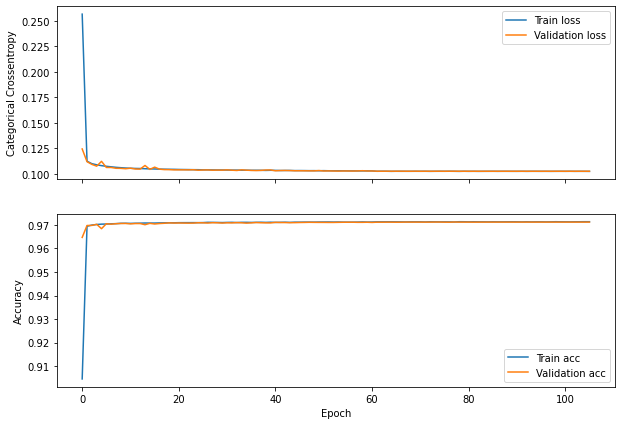

In [30]:
show_history(f'{model_cnn}/history_best_model.pkl')

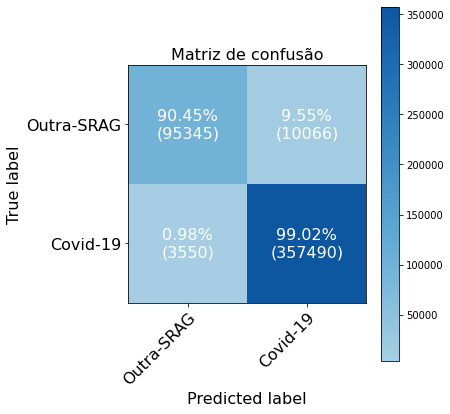

None

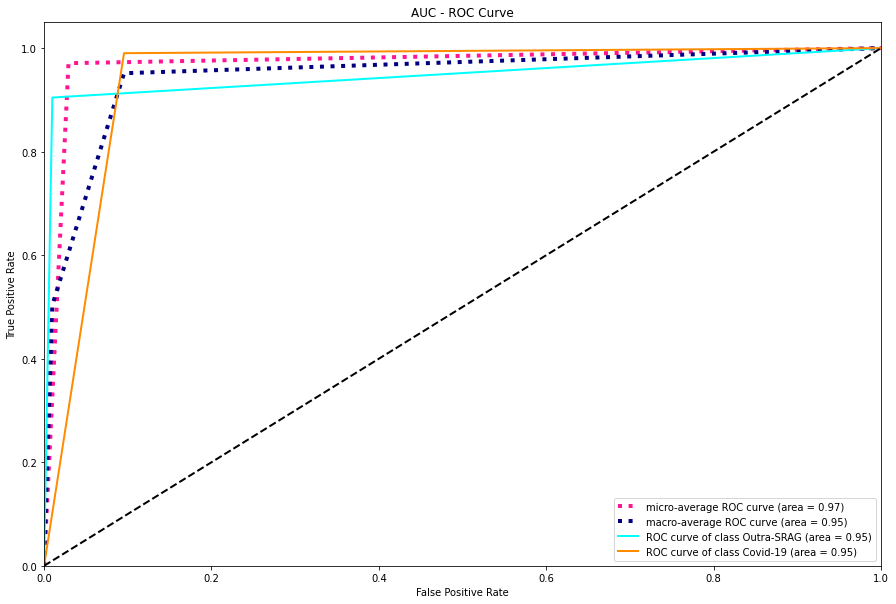

None

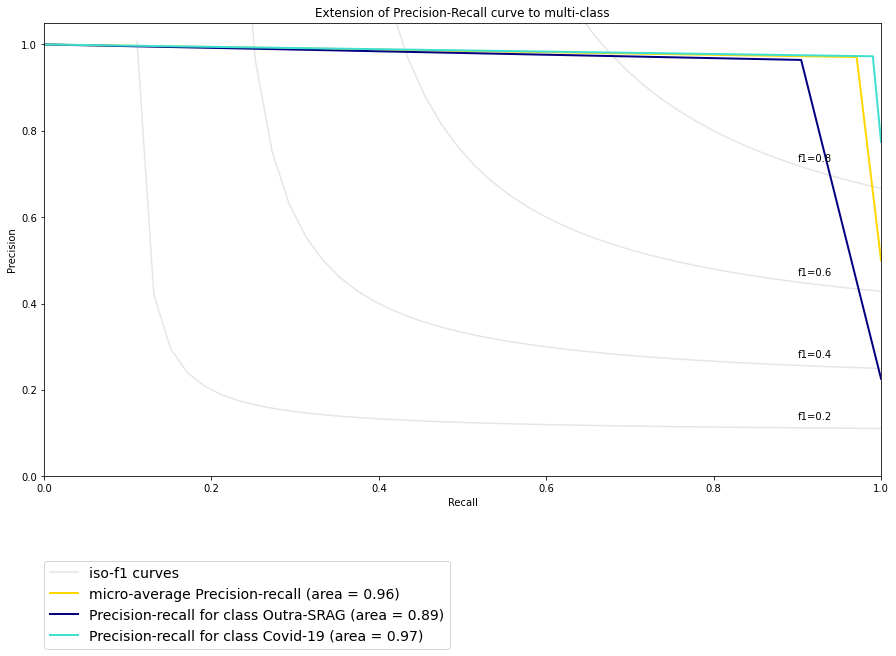

None

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,Outra-SRAG,0.93,0.95,0.89,0.96,0.90,0.99,0.97
1,Covid-19,0.98,0.95,0.97,0.97,0.99,0.90,0.97
2,Média,0.96,0.95,0.93,0.96,0.94,0.94,0.97


In [31]:
evaluate(
    model=model,
    x_test=x_test,
    y_test=y_test,
    class_names=['Outra-SRAG', 'Covid-19'],
    path=model_cnn
)

#### RNA (CNN) K-FOLD

In [28]:
cnn_kfold = f'{model_cnn}/kfold'

2021-12-12 20:54:28.169021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-12 20:54:28.169327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 20:54:28.169396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-12 20:54:28.169455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-12 20:54:28.169589: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/106
10424/10424 [==============================] - 39s 4ms/step - loss: 0.2144 - acc: 0.9239 - precision_m: 0.9239 - recall_m: 0.9239 - f1_m: 0.9239 - auc: 0.9696
Epoch 2/106
10424/10424 [==============================] - 37s 4ms/step - loss: 0.1131 - acc: 0.9692 - precision_m: 0.9692 - recall_m: 0.9692 - f1_m: 0.9692 - auc: 0.9861
Epoch 3/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1108 - acc: 0.9697 - precision_m: 0.9696 - recall_m: 0.9696 - f1_m: 0.9696 - auc: 0.9869
Epoch 4/106
10424/10424 [==============================] - 37s 4ms/step - loss: 0.1086 - acc: 0.9701 - precision_m: 0.9700 - recall_m: 0.9700 - f1_m: 0.9700 - auc: 0.9878
Epoch 5/106
10424/10424 [==============================] - 36s 3ms/step - loss: 0.1073 - acc: 0.9703 - precision_m: 0.9703 - recall_m: 0.9703 - f1_m: 0.9703 - auc: 0.9882
Epoch 6/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1064 - acc: 0.9705 - precision_m: 0.9705 - recall_m: 0.9705 - f

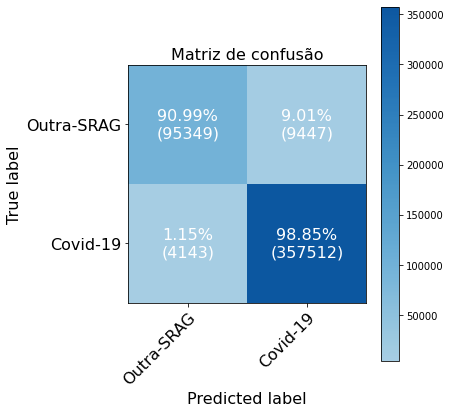

None

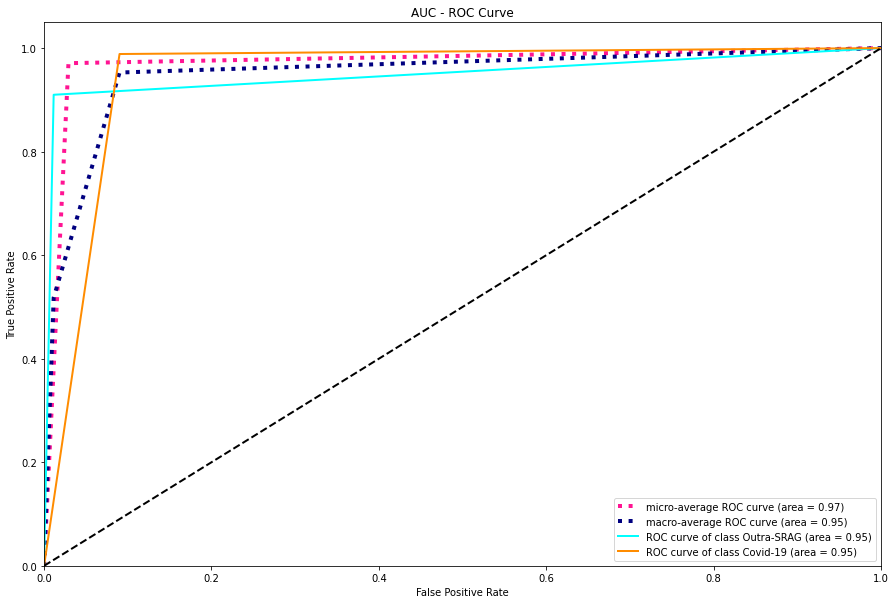

None

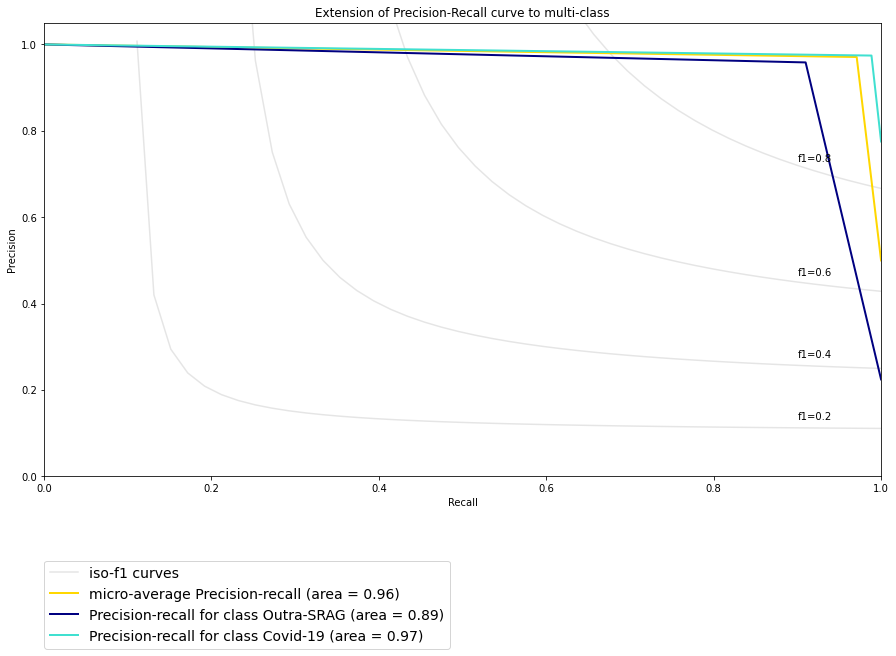

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/106
10424/10424 [==============================] - 34s 3ms/step - loss: 0.2415 - acc: 0.9111 - precision_m: 0.9111 - recall_m: 0.9111 - f1_m: 0.9111 - auc: 0.9622
Epoch 2/106
10424/10424 [==============================] - 33s 3ms/step - loss: 0.1115 - acc: 0.9696 - precision_m: 0.9696 - recall_m: 0.9696 - f1_m: 0.9696 - auc: 0.9868
Epoch 3/106
10424/10424 [==============================] - 33s 3ms/step - loss: 0.1095 - acc: 0.9700 - precision_m: 0.9699 - recall_m: 0.9699 - f1_m: 0.9699 - auc: 0.9875
Epoch 4/106
10424/10424 [==============================] - 33s 3ms/step - loss: 0.1083 - acc: 0.9702 - precision_m: 0.9702 - recall_m: 0.9

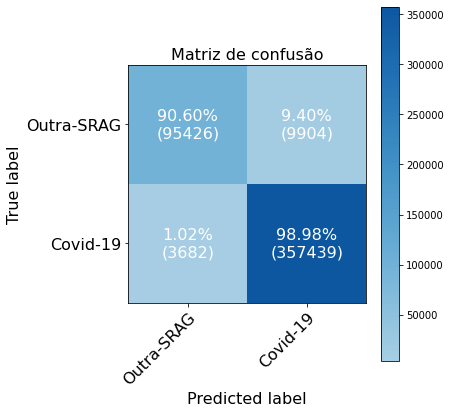

None

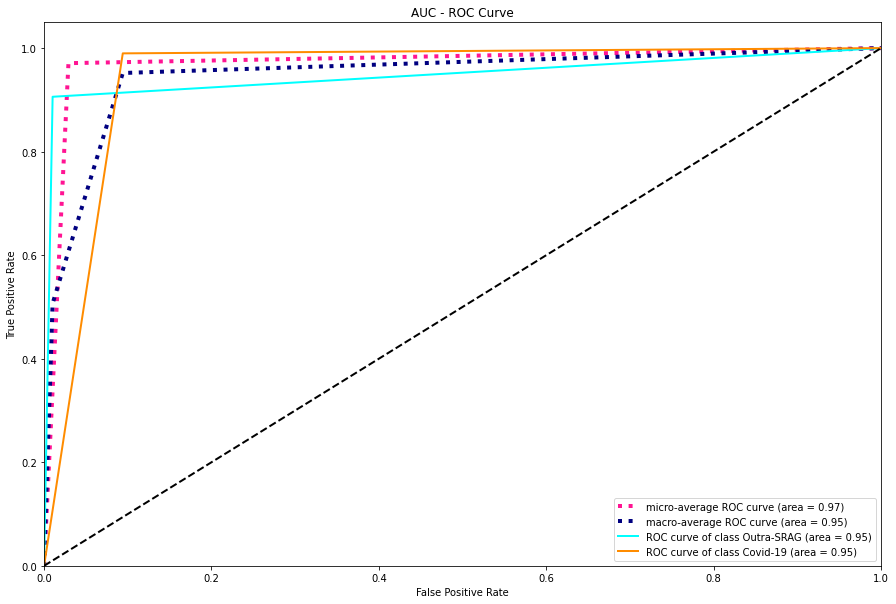

None

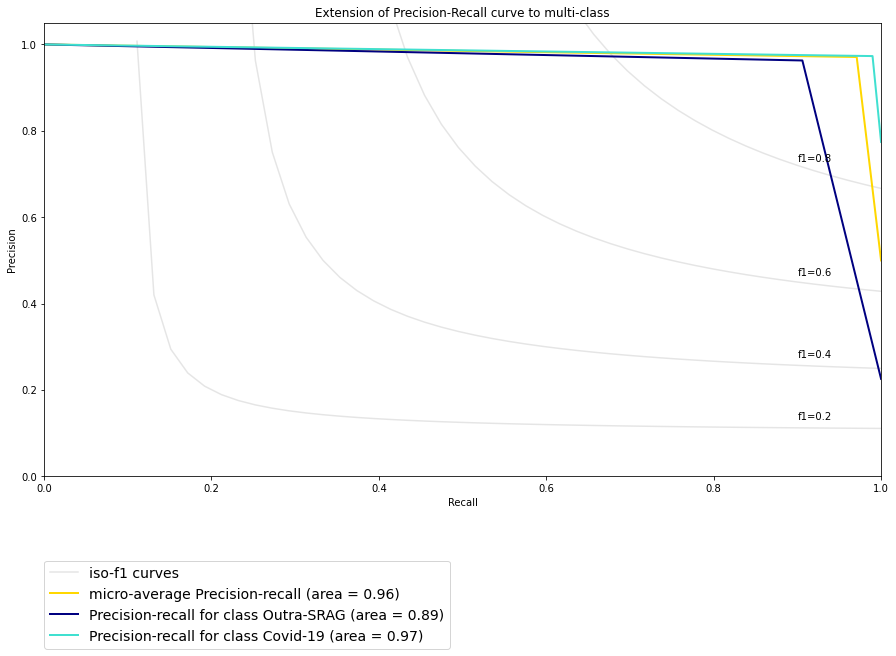

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.2129 - acc: 0.9246 - precision_m: 0.9246 - recall_m: 0.9246 - f1_m: 0.9246 - auc: 0.9699
Epoch 2/106
10424/10424 [==============================] - 34s 3ms/step - loss: 0.1120 - acc: 0.9695 - precision_m: 0.9695 - recall_m: 0.9695 - f1_m: 0.9695 - auc: 0.9866
Epoch 3/106
10424/10424 [==============================] - 34s 3ms/step - loss: 0.1093 - acc: 0.9700 - precision_m: 0.9700 - recall_m: 0.9700 - f1_m: 0.9700 - auc: 0.9876
Epoch 4/106
10424/10424 [==============================] - 34s 3ms/step - loss: 0.1075 - acc: 0.9702 - precision_m: 0.9702 - recall_m: 0.9

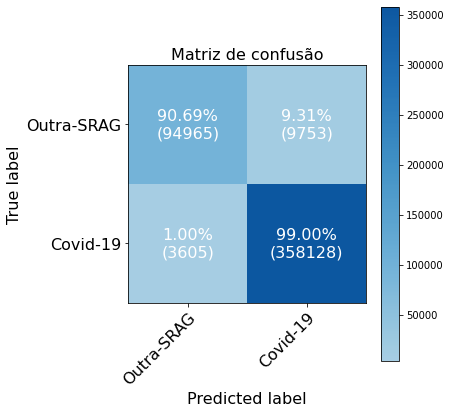

None

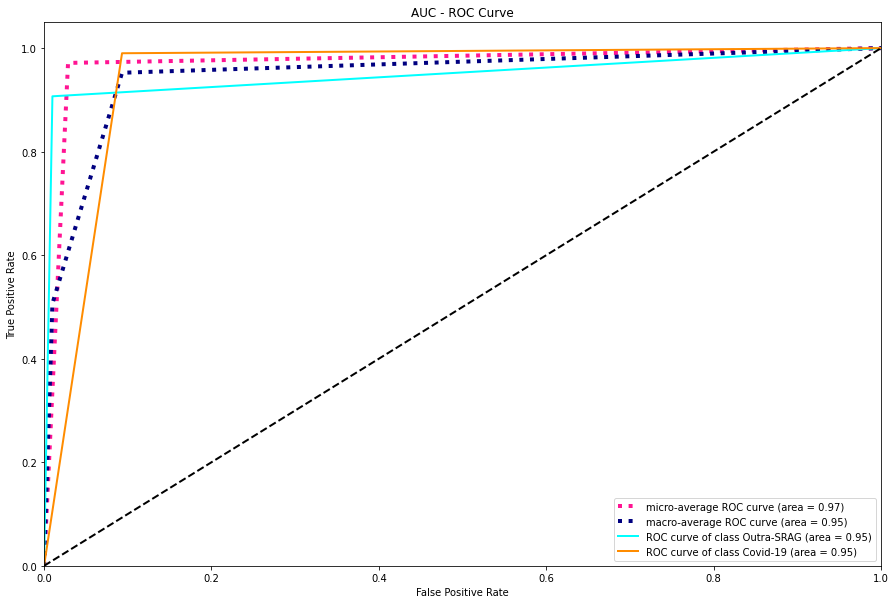

None

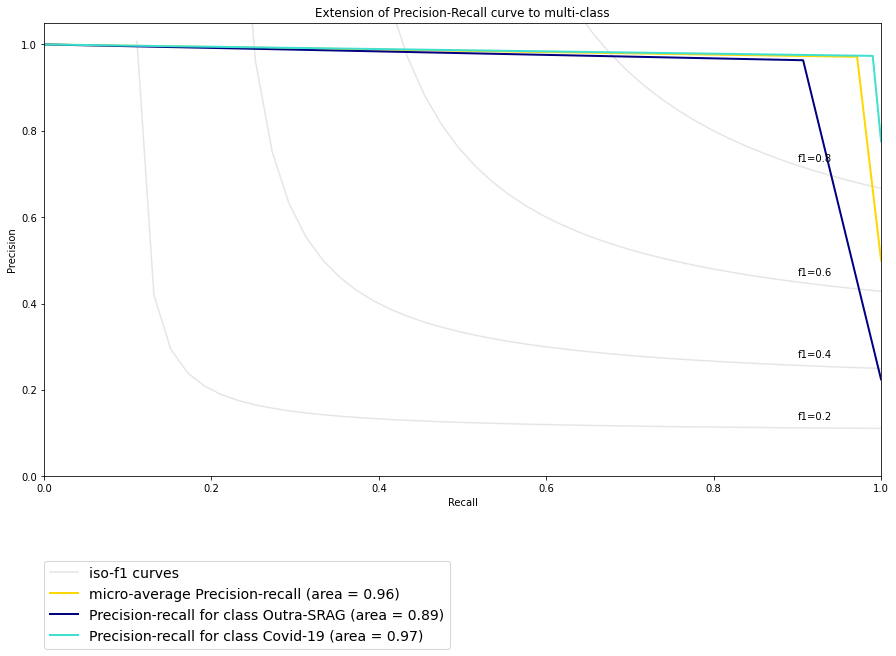

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.93     0.95     0.89       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.93       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.2281 - acc: 0.9168 - precision_m: 0.9168 - recall_m: 0.9168 - f1_m: 0.9168 - auc: 0.9662
Epoch 2/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1099 - acc: 0.9697 - precision_m: 0.9697 - recall_m: 0.9697 - f1_m: 0.9697 - auc: 0.9877
Epoch 3/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1081 - acc: 0.9700 - precision_m: 0.9700 - recall_m: 0.9700 - f1_m: 0.9700 - auc: 0.9882
Epoch 4/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1070 - acc: 0.9701 - precision_m: 0.9701 - recall_m: 0.9

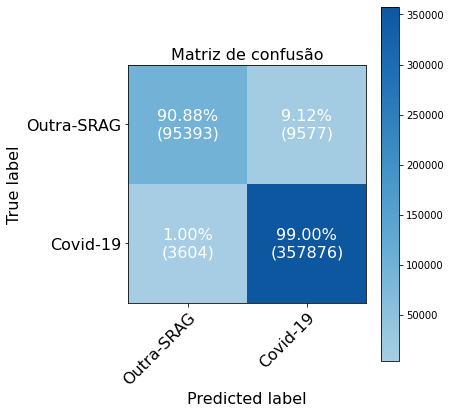

None

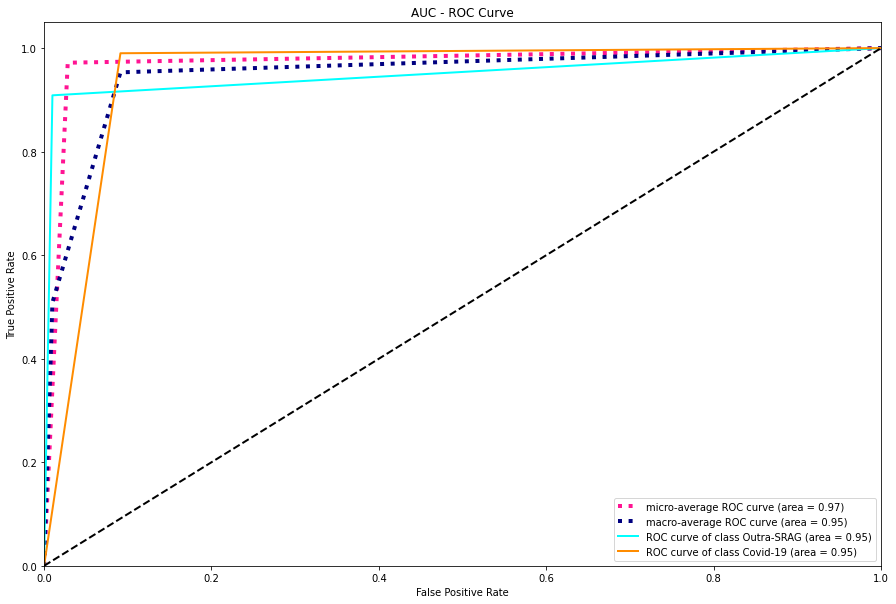

None

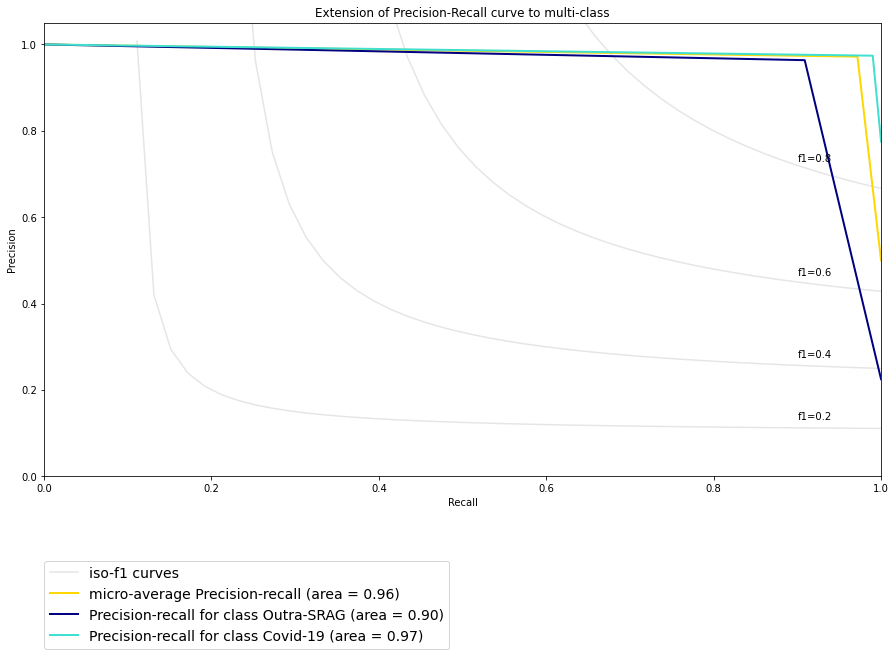

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.90       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.94       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  
Epoch 1/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.2185 - acc: 0.9222 - precision_m: 0.9222 - recall_m: 0.9222 - f1_m: 0.9222 - auc: 0.9686
Epoch 2/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1122 - acc: 0.9694 - precision_m: 0.9694 - recall_m: 0.9694 - f1_m: 0.9694 - auc: 0.9866
Epoch 3/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1102 - acc: 0.9698 - precision_m: 0.9698 - recall_m: 0.9698 - f1_m: 0.9698 - auc: 0.9873
Epoch 4/106
10424/10424 [==============================] - 35s 3ms/step - loss: 0.1089 - acc: 0.9700 - precision_m: 0.9700 - recall_m: 0.9

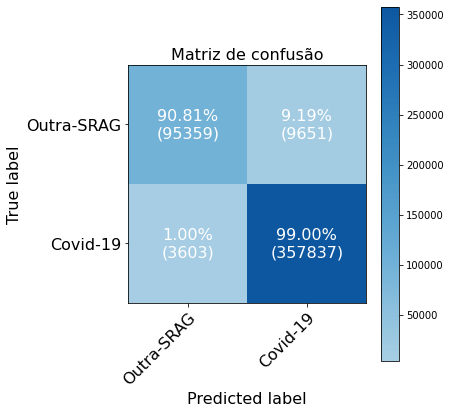

None

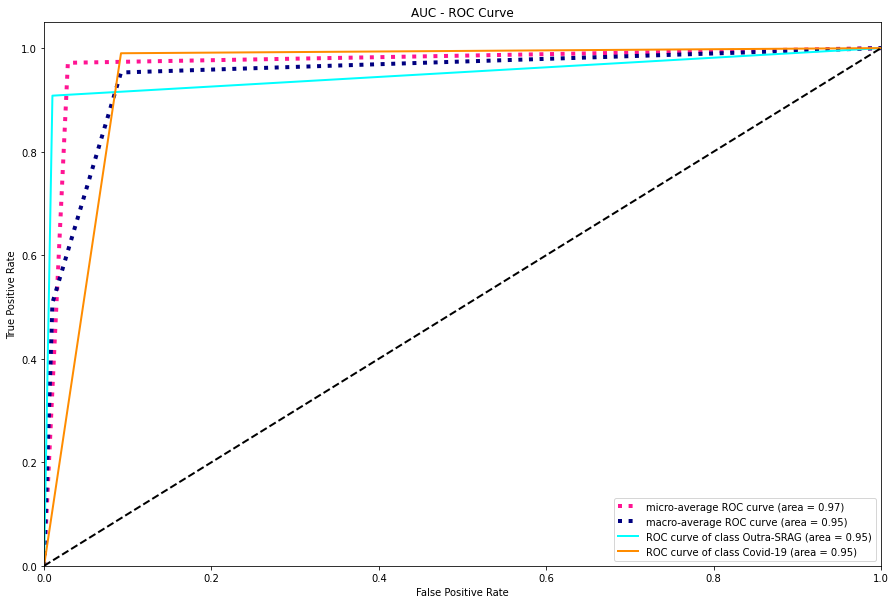

None

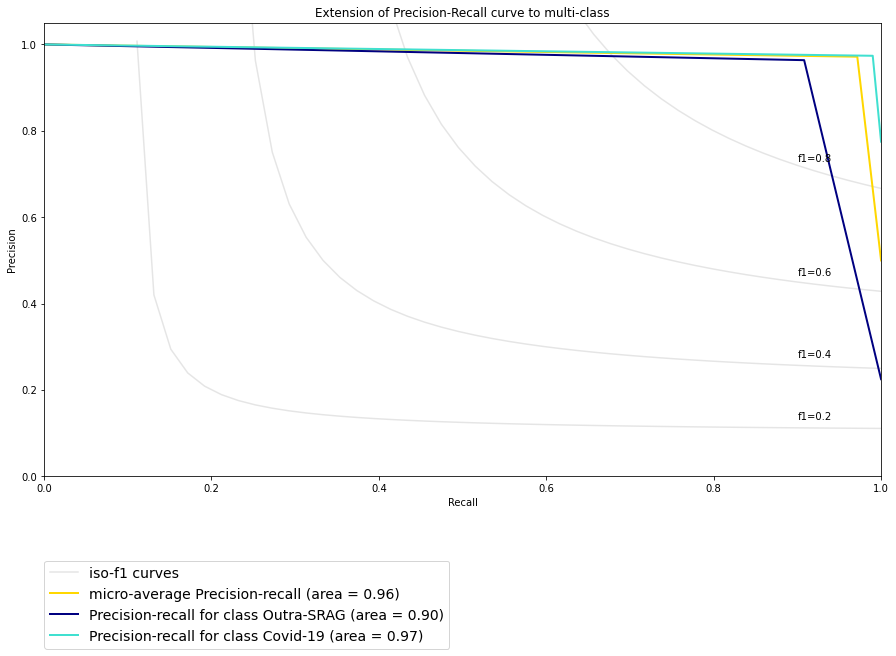

None

      Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
0  Outra-SRAG  0.94     0.95     0.90       0.96    0.91         0.99   
1    Covid-19  0.98     0.95     0.97       0.97    0.99         0.91   
2       Média  0.96     0.95     0.94       0.96    0.95         0.95   

   Accuracy  
0      0.97  
1      0.97  
2      0.97  


In [29]:
x = df[x_cols]
y = df[y_cols]

all_metrics = []
seed = 0
i = 0

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):
    
    x_scaler = MinMaxScaler(feature_range=(0, 1))

    x_train = x_scaler.fit_transform(x.values[train])
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    y_train = tf.keras.utils.to_categorical(y.values[train])

    # Load model
    model = cnn_model((x_train.shape[1],x_train.shape[2]))
    # Fit the model
    model.fit(x_train, y_train, epochs=106, batch_size=179)
    
    # evaluate the model
    x_test = x_scaler.transform(x.values[test])
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    y_pred = model.predict(x_test)
    y_true = y.values[test]
    y_pred = np.argmax(y_pred, axis=1)
    
    out = f'{cnn_kfold}/{i}fold'
    sync_path(out)
    
    lbs = ['Outra-SRAG', 'Covid-19']
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true.ravel(), y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)
    i+=1

Média e desvio padrão dos k-folds

In [30]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} {i}-fold"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{cnn_kfold}/{all_metrics[0].loc[target].Classes}_metrics.csv')

,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Outra-SRAG 0-fold,0.93,0.95,0.89,0.96,0.91,0.99,0.97
Outra-SRAG 1-fold,0.93,0.95,0.89,0.96,0.91,0.99,0.97
Outra-SRAG 2-fold,0.93,0.95,0.89,0.96,0.91,0.99,0.97
Outra-SRAG 3-fold,0.94,0.95,0.90,0.96,0.91,0.99,0.97
Outra-SRAG 4-fold,0.94,0.95,0.90,0.96,0.91,0.99,0.97
Avg,0.93,0.95,0.89,0.96,0.91,0.99,0.97
Std,0.01,0.00,0.01,0.00,0.00,0.00,0.00


,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
Covid-19 0-fold,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Covid-19 1-fold,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Covid-19 2-fold,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Covid-19 3-fold,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Covid-19 4-fold,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Avg,0.98,0.95,0.97,0.97,0.99,0.91,0.97
Std,0.00,0.00,0.00,0.00,0.00,0.00,0.00


> Developed by Patrick Silva Ferraz <patrick.ferraz@outlook.com>